# Bevezetés az adattudományba 1.

## 6. notebook (PCA + Keras)

### Kézzel írt karakterek

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

Adat beolvasása (8x8 pixeles adatok)

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

A pixelek 64 dimenziós teret definiálnak, vetítsük az adatokat az első két főkomonens által kifeszített altérre

In [4]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Vizualizáljuk az adatot a két főkomonens mentén

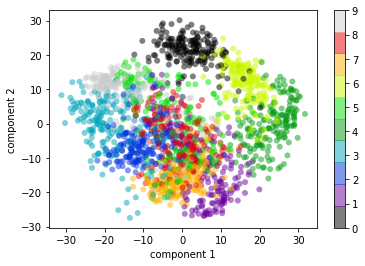

In [5]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, alpha=0.5, edgecolor='none',
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Használt főkomponensek számának meghatározása

Text(0, 0.5, 'cumulative explained variance')

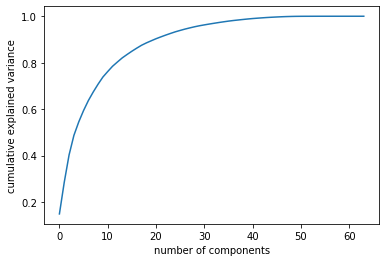

In [6]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Arcfelismerés

In [7]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
#print(faces.target_names)
print(faces.images.shape)

(1348, 62, 47)


Főkomponensanalízist fogunk végrehajtani, de a nagy dimenzióra ($62 \cdot 47 = 2914$)  való tekintettel, a PCA-t egy approximációs algoritmussal fogjuk most megvalósítani. Az első 150 főkomponenst fogjuk tekinteni.

In [8]:
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(n_components=150, svd_solver='randomized')

Tekinstük a főkomponenseket (sajátvektorokat, most: sajátarcok, eigenfaces)

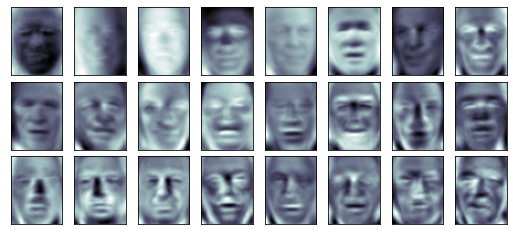

In [9]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Kicsit ijesztő... :)

Az első néhány sajátarc (balfelső sarokból) úgy tűnik, hogy az arc megvilágításának irányával függ össze, a többi főkomponens úgy tűnik, hogy egy-egy tulajdonsgáot emel ki, pl. szemek, orr, száj...

Tekintsük, hogy a vetítés mennyi információt (varianciát) őriz meg

Text(0, 0.5, 'cumulative explained variance')

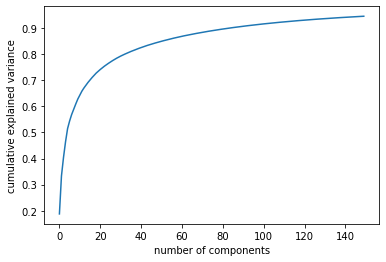

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Úgy tűnik, hogy 150 főkomponenssel már kb 95%-nyi varianciát megmagyazázhatunk, tehát 150 főkomponenssel már az arc legfőbb karakterisztikáit meg kell ragadjuk

Tekintsük tehát a vetített arcokat (az eredeti térben)

In [11]:
# Compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

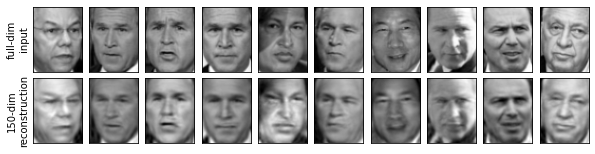

In [12]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

Kik vannak a képen?

In [13]:
[faces.target_names[i] for i in faces.target[:10]]

['Colin Powell',
 'George W Bush',
 'George W Bush',
 'George W Bush',
 'Hugo Chavez',
 'George W Bush',
 'Junichiro Koizumi',
 'George W Bush',
 'Tony Blair',
 'Ariel Sharon']

### Karakterfelismerés Keras segítségével

Pálovics Róbert nyomán

In [14]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from PIL import ImageOps
import numpy as np
from matplotlib.pyplot import imshow
sns.set(font="Droid Sans",font_scale = 2)
sns.set_style("white")
sns.set_color_codes("dark")

#### MNIST Dataset
* 28x28 pixeles képek
* lehetséges címkék: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 (többosztályos probléma)
* 28x28 = 784 attribútum
* 6000 tanító minta

In [15]:
from keras.datasets import mnist

In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

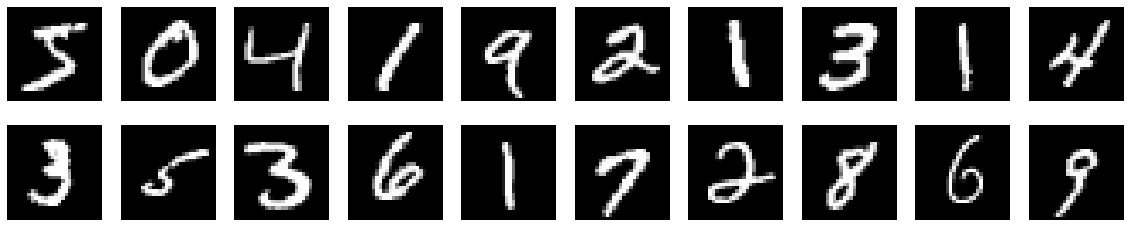

In [17]:
plt.figure(figsize=(20,4))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

In [18]:
from keras.utils import np_utils
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
y_train.shape

(60000, 10)

 #### Modellezés

In [19]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [20]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu',data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

További leírások: http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

In [21]:
accuracy = []
train_percent = 0.05
iter = 20
for i in range(iter):
    model.fit(X_train[i*int(60000*train_percent):(i+1)*int(60000*train_percent)], y_train[i*int(60000*train_percent):(i+1)*int(60000*train_percent)],batch_size=100, epochs=1,verbose=0, validation_split=0.1)
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy.append(score[1])

Text(0, 0.5, 'accuracy on the test set')

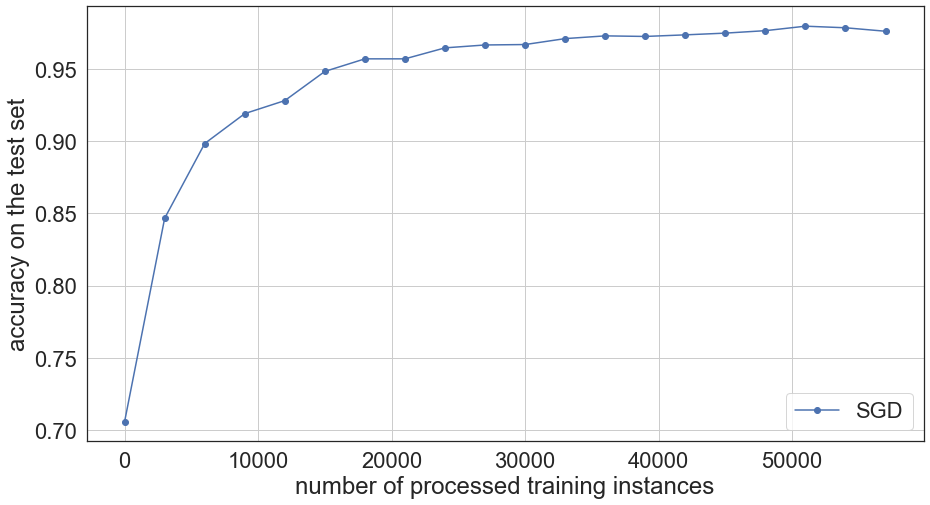

In [22]:
X = np.arange(iter)
plt.figure(figsize=(15,8))
plt.plot(X*int(train_percent*60000),accuracy,"o-",label="SGD")
plt.legend(loc=4)
plt.grid()
plt.xlabel("number of processed training instances")
plt.ylabel("accuracy on the test set")

### Tesztelés saját kézzel írt számokon

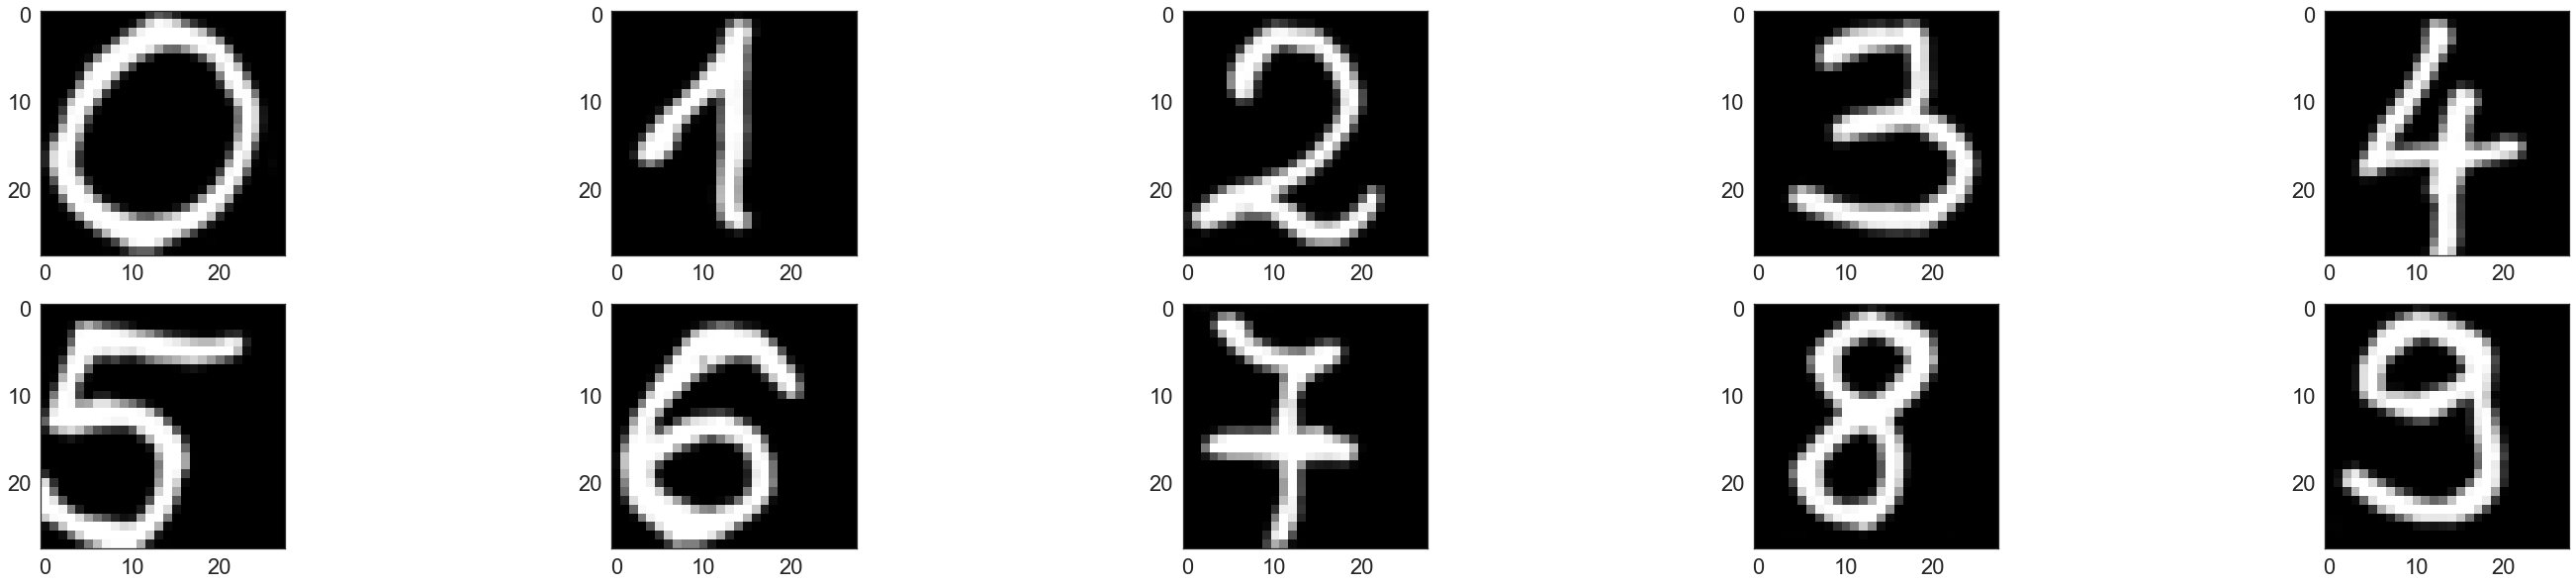

In [25]:
# visualizing hand-written digits
thresholds = {}
thresholds[ 0 ] = ( 225 , 229 , 451 , 458 )
thresholds[ 1 ] = ( 675 , 229 , 901 , 458 )
thresholds[ 2 ] = ( 1126 , 229 , 1352 , 458 )
thresholds[ 3 ] = ( 1576 , 229 , 1802 , 458 )
thresholds[ 4 ] = ( 2027 , 229 , 2253 , 458 )
thresholds[ 5 ] = ( 225 , 687 , 451 , 916 )
thresholds[ 6 ] = ( 675 , 687 , 901 , 916 )
thresholds[ 7 ] = ( 1126 , 687 , 1352 , 916 )
thresholds[ 8 ] = ( 1576 , 687 , 1802 , 916 )
thresholds[ 9 ] = ( 2027 , 687 , 2253 , 916 )

plt.figure( figsize = ( 50 , 10 ) )
for i in range( 10 ):
    image = Image.open("../Adatok/digits.jpg" )
    width, height = image.size
    image = image.crop( thresholds[ i ] )
    image = ImageOps.invert( image )
    image.thumbnail( ( 28 , 28 ) )
    image_data = np.asarray( image , dtype = np.uint8 )
    image_data = image_data.sum( 2 ).astype( float )
    image_data /= image_data.max()
    plt.subplot( 2 , 5 , i + 1 )
    plt.imshow( image_data, cmap = plt.cm.gray )

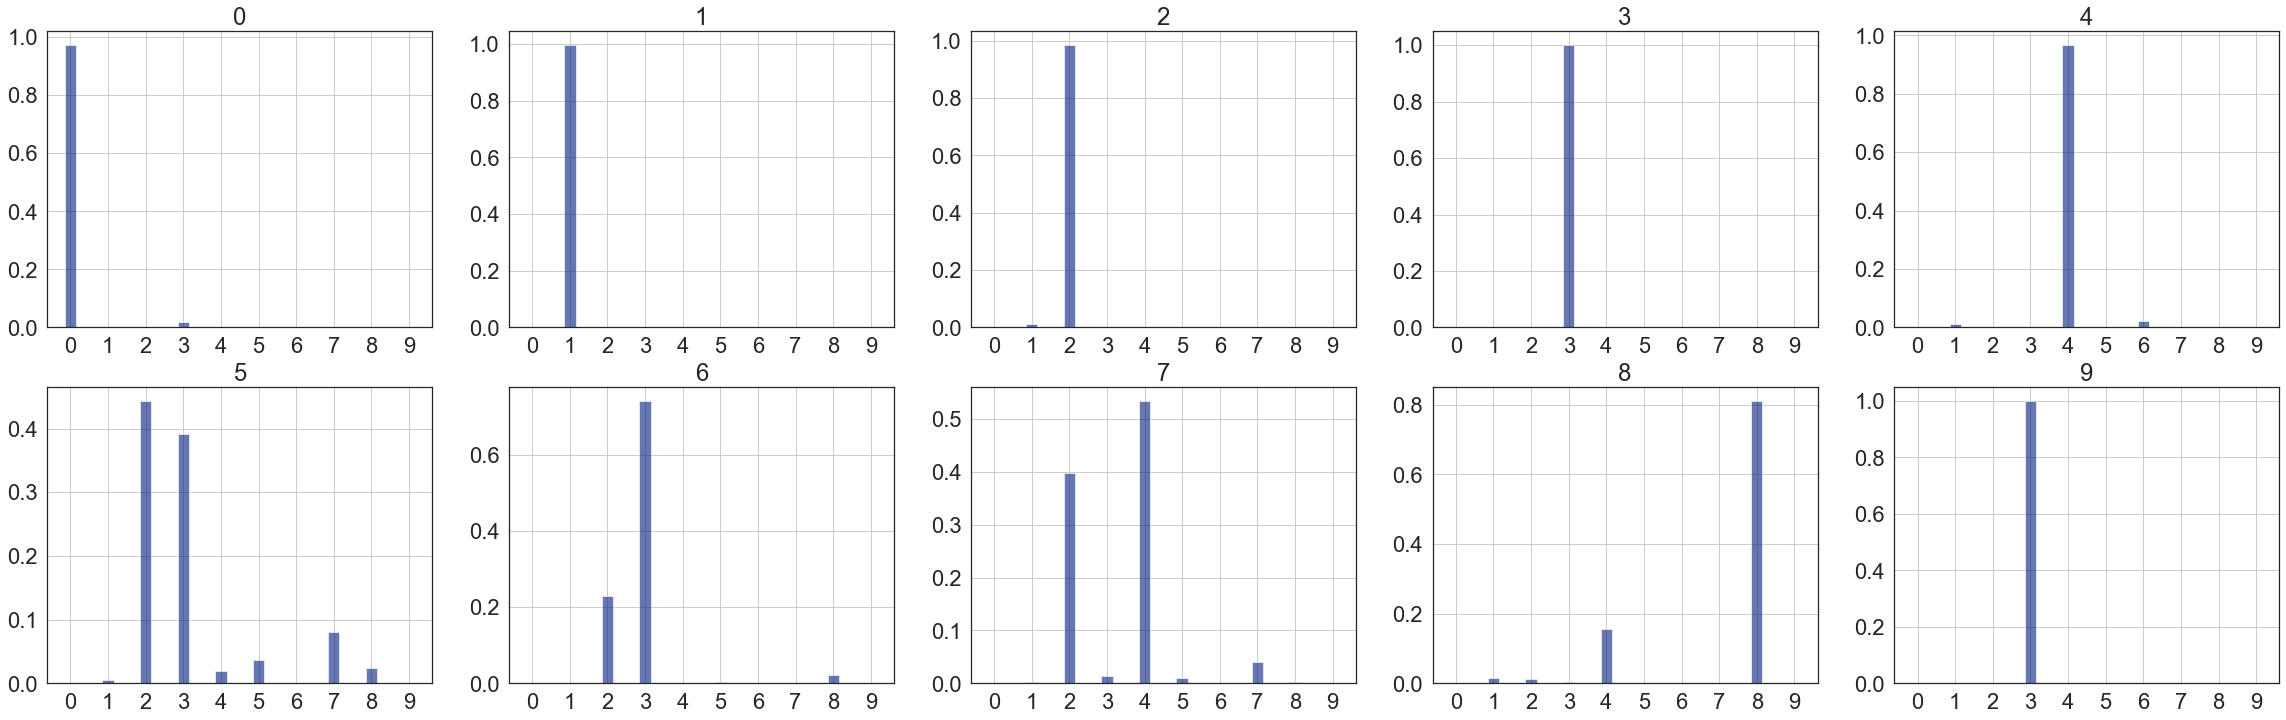

In [26]:
# using the trained model to recognize hand-written digits
plt.figure( figsize = ( 40 , 12 ) )
for i in range( 10 ):
    image = Image.open( "../Adatok/digits.jpg" )
    width, height = image.size
    image = image.crop( thresholds[ i ] )
    image = ImageOps.invert( image )
    image.thumbnail( ( 28 , 28 ) )
    image_data = np.asarray( image , dtype = np.uint8 )
    image_data = image_data.sum( 2 ).astype( float )
    image_data /= image_data.max()
    image_data = image_data.reshape(1, 28 , 28, 1 )
    predictions = model.predict( image_data > 0.8 )
    plt.subplot( 2 , 5 , i + 1 )
    plt.bar( range( 10 ) , predictions[ 0 ] , 0.3 , color = "b" , alpha = 0.6 )
    plt.title( i )
    plt.grid()
    plt.xticks( range( 10 ) )